# Artificial Neural Networks and Deep Learning

---

## Homework 1

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/AN2DL/Homework 1
# directory of my folder in google drive

## ⚙️ Import Libraries

In [ ]:
seed = 85 # random variable to make the code reproducible

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import numpy as np
import hashlib
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz') # load the blood cells dataset into a variable called 'data'
print(data.files)
# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [ ]:
# Define a mapping of labels to their corresponding digit names
classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes
# Save unique labels
unique_labels = list(classes.values())

In [ ]:
# splitting between images and labels
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)
# we have 13759 observations that are images of height and weight equal to 96 and 3 channels (RGB images)

(13759, 96, 96, 3)
(13759, 1)


In [ ]:
# show a sample of images from the training set

num_img = 50 # 50 random images
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(10, 5, figsize=(20, 20))

# iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{classes[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## Searching for duplicates: to eliminate them including the noisy images

In [ ]:
# Dictionary to store image hashes and their indices
hash_dict = {}
duplicates = []

for idx, img in enumerate(X):
    # Convert the image to bytes to create a hash
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()

    # Check if the hash exists in hash_dict
    if img_hash in hash_dict:
        # print(f"Duplicate found at index {idx}, duplicate of index {hash_dict[img_hash]}")
        duplicates.append(idx)  # Mark this index as a duplicate
    else:
        hash_dict[img_hash] = idx  # Store unique hash with its index

# Remove duplicates from X and y
X_unique = np.delete(X, duplicates, axis=0)
y_unique = np.delete(y, duplicates, axis=0)

# Save the deduplicated dataset if desired
np.savez('deduplicated_training_set.npz', images=X_unique, labels=y_unique)

print(f"Removed {len(duplicates)} duplicates. New dataset has {len(X_unique)} images.")

Removed 1806 duplicates. New dataset has 11953 images.


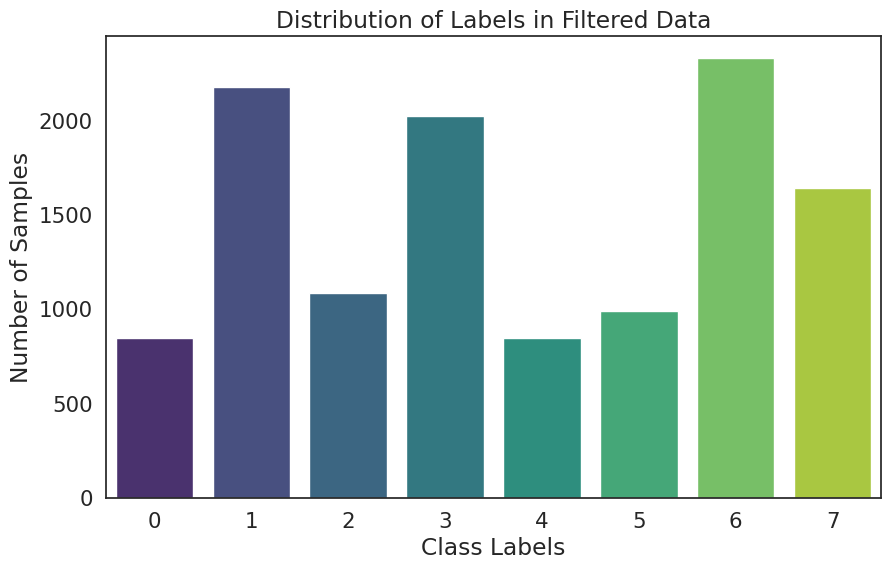

In [ ]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y_unique, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

In [ ]:
# DOWNSAMPLING

class_dimension = 1000 # number of obs I want for each class

# to memorize the subsampling
subsample_images = []
subsample_labels = []

# loop for the 8 classes
for label in np.unique(y_unique):

    # Obtaining image indexes belonging to the class
    indices = np.where( y_unique == label)[0]

    # If the class is bigger than class_dimension it randomly downsample the class
    if len(indices) > class_dimension:
        selected_indices = np.random.choice(indices, class_dimension, replace=False)
    else:
        selected_indices = indices  # Se sono <= 1049, usa tutti gli indici

    #  Add images and labels
    subsample_images.extend(X_unique[selected_indices])
    subsample_labels.extend(y_unique[selected_indices])

# Array conversion
X_down = np.array(subsample_images)
y_down = np.array(subsample_labels)

print('Downsampling done. New dimension: ', len(subsample_images))
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_down, columns=['digit'])['digit'].value_counts())

Downsampling done. New dimension:  6799
Counting occurrences of target classes:
digit
0    850
1    850
2    850
3    850
5    850
6    850
7    850
4    849
Name: count, dtype: int64


In [ ]:
# Normalization: important to make image augmentation

X_down = X_down / 255

Immagine originale:
Original - Min: 0.023529411764705882, Max: 1.0, Mean: 0.6520246119281046


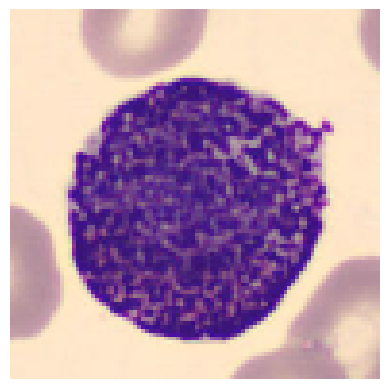

Immagine augmentata:
Augmented - Min: 0.0235294122248888, Max: 1.0, Mean: 0.6520245671272278


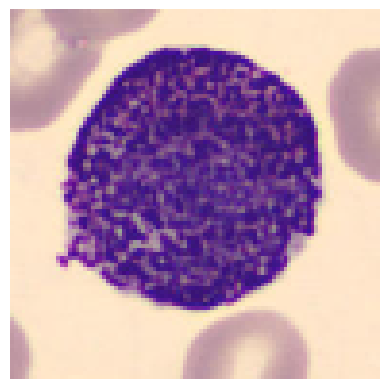

In [ ]:
# Function to observe range values of the image
def print_image_stats(img, name="Image"):
    print(f"{name} - Min: {np.min(img)}, Max: {np.max(img)}, Mean: {np.mean(img)}")

# Function to show an image
def show_image(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

y_one = np.squeeze(y_down)

# Example - selecting an image from class 0
class_images = X_down[y_one == 0]
original_img = class_images[np.random.randint(0, len(class_images))]

# Show the image and print values
print("Immagine originale:")
print_image_stats(original_img, name="Original")
show_image(original_img)

# Configuration of a test augmentation
augmentation_flip = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical")  # Flip
])

# Apply augmentation
augmented_img = augmentation_flip(tf.expand_dims(original_img, axis=0), training=True)

augmented_img = tf.squeeze(augmented_img, axis=0).numpy()

# Print the augmented image
print("Immagine augmentata:")
print_image_stats(augmented_img, name="Augmented")
show_image(augmented_img)

##Data Augmentation

In [ ]:
# LOW LOW
augmentation_low_low = tf.keras.Sequential([
    tfkl.RandomZoom(0.1),
    tfkl.RandomFlip('horizontal'),
    tfkl.RandomTranslation(0.1, 0.1),
    tfkl.RandomRotation(0.1),
    tfkl.RandomBrightness(0.1, value_range=(0, 1)),
    tfkl.RandomContrast(0.1),
], name='preprocessing_low_new')

# LOW
augmentation_low = tf.keras.Sequential([
    tfkl.RandomZoom(0.2),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.2, 0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomBrightness(0.2, value_range=(0, 1)),
    tfkl.RandomContrast(0.2),
], name='preprocessing')

# MEDIUM
augmentation_med = tf.keras.Sequential([
    tfkl.RandomZoom(0.4),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomBrightness(0.4, value_range=(0, 1)),
    tfkl.RandomContrast(0.4),
], name='preprocessing')

# HIGH
augmentation_high = tf.keras.Sequential([
    tfkl.RandomZoom(0.6),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomBrightness(0.6, value_range=(0, 1)),
    tfkl.RandomContrast(0.6),
], name='preprocessing')

# VERY HIGH
augmentation_vhigh = tf.keras.Sequential([
    tfkl.RandomZoom(0.6),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomBrightness(0.8, value_range=(0, 1)),
    tfkl.RandomContrast(0.8),
], name='preprocessing')

In [ ]:
# MIXED 1
m1 = tf.keras.Sequential([
    tfkl.RandomZoom(0.3),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.2, 0.3),
    tfkl.RandomRotation(0.3),
    tfkl.RandomBrightness(0.3, value_range=(0, 1)),
    tfkl.RandomContrast(0.2),
], name='preprocessing_med_new')

# MIXED 2
m2 = tf.keras.Sequential([
    tfkl.RandomZoom(0.5),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.3, 0.3),
    tfkl.RandomRotation(0.5),
    tfkl.RandomBrightness(0.5, value_range=(0, 1)),
    tfkl.RandomContrast(0.5),
], name='preprocessing_high_new')

# MIXED 3
m3 = tf.keras.Sequential([
    tfkl.RandomZoom(0.7),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.5, 0.5),
    tfkl.RandomRotation(0.7),
    tfkl.RandomBrightness(0.7, value_range=(0, 1)),
    tfkl.RandomContrast(0.7),
], name='preprocessing_vhigh_new')

# MIXED 4
m4 = tf.keras.Sequential([
    tfkl.RandomZoom(0.7),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.5, 0.5),
    tfkl.RandomRotation(0.7),
    tfkl.RandomBrightness(0.3, value_range=(0, 1)),
    tfkl.RandomContrast(0.2),
], name='preprocessing_vhigh_new')

In [ ]:
# NEW AUGMENTATIONS WITH CROMATIC VARIABILITY

from tensorflow.keras.layers import Layer

# RANDOM SATURATION
class RandomSaturation(Layer):
    def __init__(self, lower=0.5, upper=1.5, **kwargs):
        super().__init__(**kwargs)
        self.lower = lower
        self.upper = upper

    def call(self, inputs, training=None):
        if training:
            saturation_factor = tf.random.uniform([], self.lower, self.upper)
            return tf.image.adjust_saturation(inputs, saturation_factor)
        return inputs

# RANDOM HUE
class RandomHue(Layer):
    def __init__(self, max_delta=0.2, **kwargs):
        super().__init__(**kwargs)
        self.max_delta = max_delta

    def call(self, inputs, training=None):
        if training:
            return tf.image.adjust_hue(inputs, tf.random.uniform([], -self.max_delta, self.max_delta))
        return inputs

c1 = tf.keras.Sequential([
    tfkl.RandomZoom(0.2),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.2, 0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomBrightness(0.2, value_range=(0, 1)),
    tfkl.RandomContrast(0.2),
    RandomSaturation(0.8, 1.2),
    RandomHue(0.1),
], name='augmentation_low')

c2 = tf.keras.Sequential([
    tfkl.RandomZoom(0.4),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomBrightness(0.4, value_range=(0, 1)),
    tfkl.RandomContrast(0.4),
    RandomSaturation(0.7, 1.3),
    RandomHue(0.2),
], name='augmentation_med')

c3 = tf.keras.Sequential([
    tfkl.RandomZoom(0.6),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomBrightness(0.6, value_range=(0, 1)),
    tfkl.RandomContrast(0.6),
    RandomSaturation(0.5, 1.5),
    RandomHue(0.3),
], name='augmentation_high')

c4 = tf.keras.Sequential([
    tfkl.RandomZoom(0.6),
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomBrightness(0.8, value_range=(0, 1)),
    tfkl.RandomContrast(0.8),
    RandomSaturation(0.4, 1.6),
    RandomHue(0.4),
], name='augmentation_vhigh')

# CROMATIC
cr1 = RandomHue(0.2)
cr2 = RandomHue(0.4)
cr3 = RandomHue(0.6)
cr4 = RandomHue(0.7)
sat1 = RandomSaturation(0.2, 1.6)
sat2 = RandomSaturation(0.7, 1.5)
sat3 = RandomSaturation(0.4, 1.4)
sat4 = RandomSaturation(0.6, 1.2)

In [ ]:
# ONLY ZOOM
augmentation_zoom_l = tf.keras.Sequential([tfkl.RandomZoom(0.2)])
augmentation_zoom_m = tf.keras.Sequential([tfkl.RandomZoom(0.4)])
augmentation_zoom_h = tf.keras.Sequential([tfkl.RandomZoom(0.6)])

In [ ]:
# ONLY TRANSLATION
augmentation_tra_l = tf.keras.Sequential([tfkl.RandomTranslation(0.2,0.2)])
augmentation_tra_m = tf.keras.Sequential([tfkl.RandomTranslation(0.4,0.4)])
augmentation_tra_h = tf.keras.Sequential([tfkl.RandomTranslation(0.6,0.6)])

In [ ]:
# ONLY ROTATION
augmentation_rot_l = tf.keras.Sequential([tfkl.RandomRotation(0.2)])
augmentation_rot_m = tf.keras.Sequential([tfkl.RandomRotation(0.4)])
augmentation_rot_h = tf.keras.Sequential([tfkl.RandomRotation(0.6)])

In [ ]:
# ONLY BRIGHTNESS
augmentation_bri_l = tf.keras.Sequential([tfkl.RandomBrightness(0.2, value_range=(0, 1))])
augmentation_bri_m = tf.keras.Sequential([tfkl.RandomBrightness(0.4, value_range=(0, 1))])
augmentation_bri_h = tf.keras.Sequential([tfkl.RandomBrightness(0.6, value_range=(0, 1))])

In [ ]:
# Augmentation list
augmentations = [
    augmentation_vhigh,
    augmentation_high,
    augmentation_med,
    augmentation_low,
    augmentation_zoom_l,
    augmentation_zoom_m,
    augmentation_zoom_h,
    augmentation_tra_l,
    augmentation_tra_m,
    augmentation_tra_h,
    augmentation_rot_l,
    augmentation_rot_m,
    augmentation_rot_h,
    augmentation_bri_l,
    augmentation_bri_m,
    augmentation_bri_h,
    augmentation_low_low,
    c1, c2, c3, c4,
    m1, m2, m3, m4,
    cr1, cr2, cr3, cr4,
    sat1, sat2, sat3, sat4
]

# Parameters
N = 800  # Number of random images selected FOR EACH CLASS

# classes from 0 to 7
classi_uniche = np.unique(y_down)

# Memory variables
nuove_immagini = []
nuovi_labels = []

# Random selection
for classe in classi_uniche:

    # See obs indexes of the class
    indici_classe = np.where(y_one == classe)[0]

    # Selection of N random indexes
    indici_random = np.random.choice(indici_classe, N, replace=False)

    # For each image apply one augmentation (randomly from the list)
    for indice in indici_random:
        immagine = X_down[indice] # image selection
        augmentation = np.random.choice(augmentations)  # Augmentation selection
        immagine_aug = augmentation(np.expand_dims(immagine, axis=0))  # Application

        # Save the new image
        nuove_immagini.append(immagine_aug[0])
        nuovi_labels.append(classe)

# Array conversion
nuove_immagini = np.array(nuove_immagini)
nuovi_labels = np.array(nuovi_labels)

# Add the new samples to the original dataset
X_down_augmented = np.concatenate([X_down, nuove_immagini], axis=0)
y_down_augmented = np.concatenate([y_one, nuovi_labels], axis=0)

In [ ]:
print('Augmentation done. New dimension: ', len(X_down_augmented))
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_down_augmented, columns=['digit'])['digit'].value_counts())

Augmentation done. New dimension:  9999
Counting occurrences of target classes:
digit
0    1250
1    1250
2    1250
3    1250
5    1250
6    1250
7    1250
4    1249
Name: count, dtype: int64


In [ ]:
# SEE SOME SAMPLES

num_samples = 40 # number of sample that we want to visualize

# Random samples selection
indici_random = np.random.choice(len(X_down_augmented), num_samples, replace=False)

# Images extraction
campioni_random = X_down_augmented[indici_random]

# Plot
fig, axes = plt.subplots(8, 5, figsize=(15, 20))  # 8 raws, 5 columns
axes = axes.flatten()

# Show images
for i, ax in enumerate(axes):
    if i < len(campioni_random):
        ax.imshow(campioni_random[i])
        ax.axis('off')
        ax.set_title(f"Campione {i+1}")  # Image title
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# keeping 80% for the training set and 20% for the validation
X_train, X_val, y_train, y_val = train_test_split(X_down_augmented, y_down_augmented, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (7999, 96, 96, 3) (7999,)
Validation: (2000, 96, 96, 3) (2000,)


## Data Balancing

In [ ]:
# compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weight_dict)

{0: 1.0048994974874372, 1: 1.0089556004036326, 2: 1.0008758758758758, 3: 1.0192405708460754, 4: 0.9919394841269841, 5: 1.0089556004036326, 6: 0.9735881207400194, 7: 0.9929245283018868}


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 6


In [ ]:
print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')
print(f'Esempio di y_train: {y_train[:5]}')
print(f'Esempio di y_val: {y_val[:5]}')

y_train shape: (7999, 8), y_val shape: (2000, 8)
Esempio di y_train: [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
Esempio di y_val: [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


## Network Parameters

In [ ]:
input_shape = (96,96,3) # input shape our dataset
output_shape = y_train.shape[1] # output shape: 8 classes
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# it makes sense because the input shape is the dimension of the image and 3 channels
# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
epochs = 300 # epochs
batch_size = 32 # batch
learning_rate = 0.00001 # step size for updating the model's weights

# Initialise configuration for convolutional layers
stack = 1 # solo un layer
filters = 32 # convolutional layers
kernel_size = 3

In [ ]:
# early stopping
patience = 50

early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'max',
    patience = patience,
    restore_best_weights = True
)

callbacks = [early_stopping]

## 🛠️ Train and Save the Model - INCEPTION-V3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input

X_train = preprocess_input(X_train)  # Preprocessing manuale
X_val = preprocess_input(X_val)

# RETE PRE ADDESTRATA
model = InceptionV3(
    input_shape=(96, 96, 3),
    include_top=False, # in pratica sto togliendo il dense layer per risolvere un mio task enon la classificazione
    weights='imagenet',
    pooling='avg',
    #include_preprocessing=True # trasforma un po' le immagini
)

# Freeze all layers in InceptionV3 to use it solely as a feature extractor
model.trainable = False

# input layer
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# applico image augmentation
#x = augmentation_choosen(inputs)

# Uso lo strato della rete
x = model(inputs)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout0')(x)

# Strato denso finale per la classificazione (output)
x = tfkl.Dense(256, activation='relu')(x)
x = tfkl.BatchNormalization(name='batch1')(x)
x = tfkl.Dropout(0.3, name='dropout1')(x)
x = tfkl.Dense(128, activation='relu')(x)
x = tfkl.BatchNormalization(name='batch2')(x)
x = tfkl.Dropout(0.3, name='dropout2')(x)

outputs = tfkl.Dense(8, activation='softmax', name='denseo')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
# OPTIMIZER 'sgd'??

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)] # restore serve per il best model
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model.save('weights.keras')

Epoch 1/300


I0000 00:00:1731938829.957071     444 service.cc:145] XLA service 0x57b4fafba5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731938829.957128     444 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731938829.957133     444 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.1439 - loss: 2.7776   

I0000 00:00:1731938840.722284     444 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.3663 - loss: 1.9756 - val_accuracy: 0.5535 - val_loss: 1.2755
Epoch 2/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5035 - loss: 1.4160 - val_accuracy: 0.5950 - val_loss: 1.1174
Epoch 3/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5301 - loss: 1.3139 - val_accuracy: 0.6040 - val_loss: 1.0802
Epoch 4/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5479 - loss: 1.2462 - val_accuracy: 0.6040 - val_loss: 1.0595
Epoch 5/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5587 - loss: 1.2317 - val_accuracy: 0.6000 - val_loss: 1.0464
Epoch 6/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5699 - loss: 1.1912 - val_accuracy: 0.6150 - val_loss: 1.0275
Epoch 7/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5738 - loss: 1.1592 - val_accuracy: 0.6230 - val_loss: 1.0101
Epoch 8/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5794 - loss: 1.1568 - val_accura

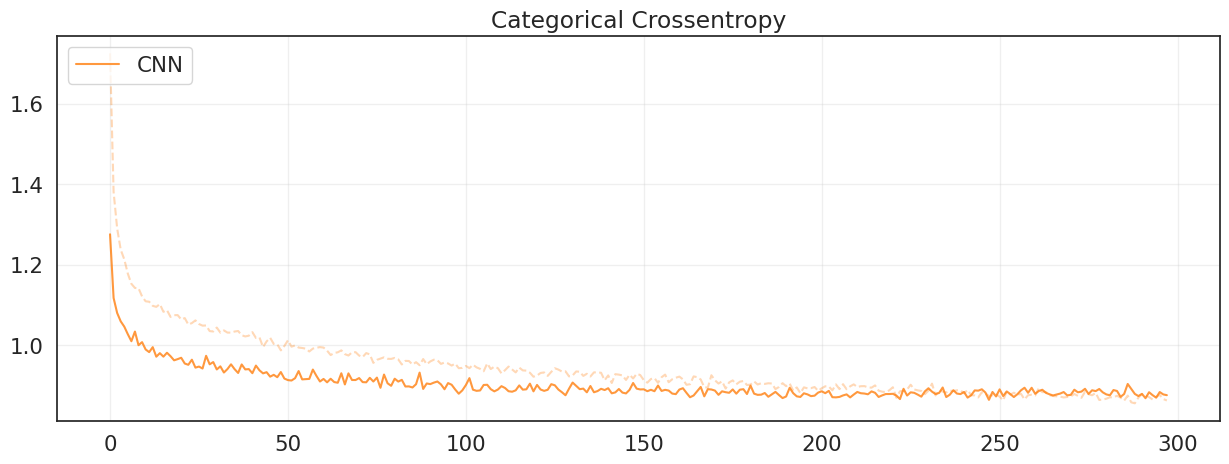

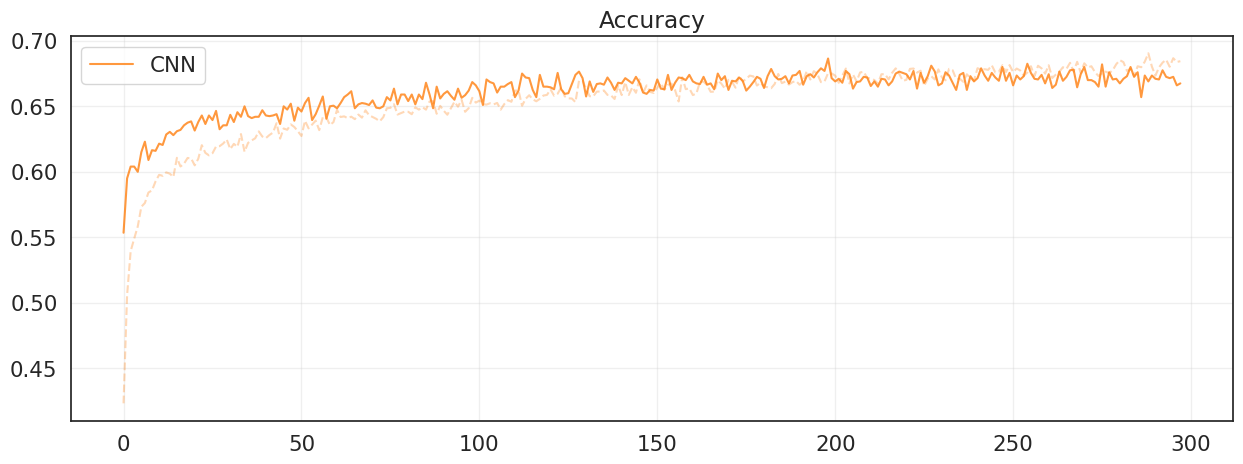

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

In [ ]:
# Predict probabilities for the test set
y_prob = model.predict(X_val)

# Convert probabilities to predicted class labels
y_pred = y_prob.argmax(axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step


In [ ]:
del model

### Validation set metrics

In [ ]:
print(f"y_val shape: {y_val.shape}, y_pred shape: {y_pred.shape}")
print(f"y_val example: {y_val[:7]}")
print(f"y_pred example: {y_pred[:7]}")

y_val shape: (2000, 8), y_pred shape: (2000,)
y_val example: [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
y_pred example: [6 1 2 2 5 1 0]


In [ ]:
y_val_categorical = y_val.argmax(axis=1)  # Converte one-hot a indici

Accuracy: 0.6800
F1 Score: 0.6782

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69       255
           1       0.67      0.60      0.63       259
           2       0.75      0.68      0.71       251
           3       0.52      0.48      0.50       269
           4       0.77      0.74      0.76       241
           5       0.51      0.56      0.53       259
           6       0.83      0.77      0.80       223
           7       0.74      0.95      0.83       243

    accuracy                           0.68      2000
   macro avg       0.69      0.69      0.68      2000
weighted avg       0.68      0.68      0.68      2000



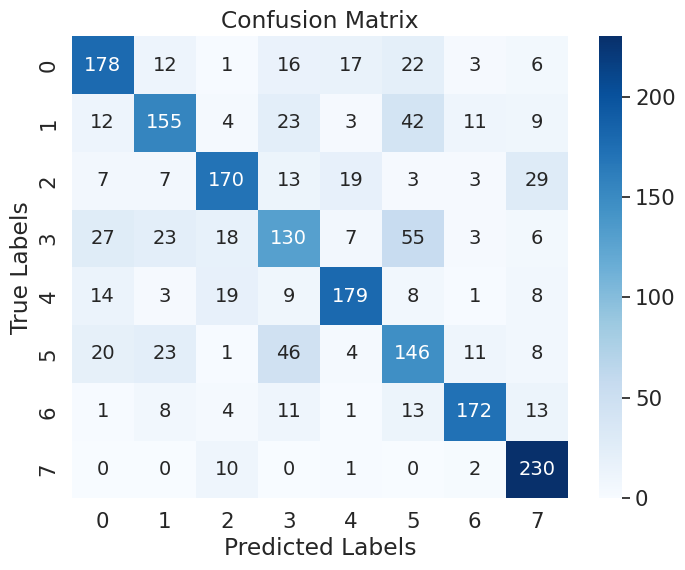

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Calculate metrics
accuracy = accuracy_score(y_val_categorical, y_pred)
f1 = f1_score(y_val_categorical, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed per-class metrics
print("\nClassification Report:\n", classification_report(y_val_categorical, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_val_categorical, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the plot
plt.show()

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print("Distribuzione delle classi nei dati di training:", dict(zip(unique, counts)))

Distribuzione delle classi nei dati di training: {0.0: 55993, 1.0: 7999}


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
import os
from datetime import datetime

# Definisci il nome del file di output con timestamp
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Crea una directory per il salvataggio del modello e dello script (se non esiste già)
output_dir = '/kaggle/working/'  # Directory di lavoro di Kaggle
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Aggiungi i file alla compressione zip
os.system(f'zip -r {output_dir}/{filename} model.py weights.keras')

# Ora il file .zip è pronto nella directory '/kaggle/working/'
print(f"File salvato come {output_dir}/{filename}")

	zip warning: name not matched: weights.keras
  adding: model.py (deflated 56%)
File salvato come /kaggle/working//submission_241118_143858.zip
